其实就是去基线的Actor_Critic算法

Actor_Critic算法中使用critic模型估计state的价值,也就是估计Q

这样估计出来的Q是没有去基线的,而要去基线也非常简单,target-value即可

换个角度来想这个问题,target是根据next_state估计出来的,value是根据state估计出来的

所以两者的差值可以视为action好坏的衡量,这可以作为actor模型训练的依据

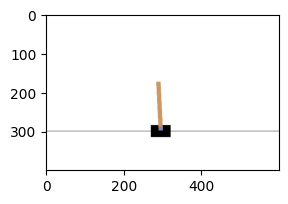

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

#演员模型,计算每个动作的概率
model_actor = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
    torch.nn.Softmax(dim=1),
)

#评委模型,计算每个状态的价值
model_critic = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_critic_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

model_critic_delay.load_state_dict(model_critic.state_dict())

model_actor, model_critic

(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
   (5): Softmax(dim=1)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=1, bias=True)
 ))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        #根据概率采样
        prob = model_actor(torch.FloatTensor(s).reshape(1, 4))[0].tolist()
        a = random.choices(range(2), weights=prob, k=1)[0]

        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state).reshape(-1, 4)
    action = torch.LongTensor(action).reshape(-1, 1)
    reward = torch.FloatTensor(reward).reshape(-1, 1)
    next_state = torch.FloatTensor(next_state).reshape(-1, 4)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

d:\it_project\github_sync\ml-workshop\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\User\AppData\Local\Temp\ipykernel_2820\2154798901.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor(state).reshape(-1, 4)


-990.0

In [4]:
optimizer_actor = torch.optim.Adam(model_actor.parameters(), lr=1e-3)
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=1e-2)


def requires_grad(model, value):
    for param in model.parameters():
        param.requires_grad_(value)

In [5]:
def train_critic(state, reward, next_state, over):
    requires_grad(model_actor, False)
    requires_grad(model_critic, True)

    #计算values和targets
    value = model_critic(state)

    with torch.no_grad():
        target = model_critic_delay(next_state)
    target = target * 0.99 * (1 - over) + reward

    #时序差分误差,也就是tdloss
    loss = torch.nn.functional.mse_loss(value, target)

    loss.backward()
    optimizer_critic.step()
    optimizer_critic.zero_grad()

    #减去value相当于去基线
    return (target - value).detach()


value = train_critic(state, reward, next_state, over)

value.shape

torch.Size([11, 1])

In [6]:
def train_actor(state, action, value):
    requires_grad(model_actor, True)
    requires_grad(model_critic, False)

    #重新计算动作的概率
    prob = model_actor(state)
    prob = prob.gather(dim=1, index=action)

    #根据策略梯度算法的导函数实现
    #函数中的Q(state,action),这里使用critic模型估算
    prob = (prob + 1e-8).log() * value
    loss = -prob.mean()

    loss.backward()
    optimizer_actor.step()
    optimizer_actor.zero_grad()

    return loss.item()


train_actor(state, action, value)

-72.2009048461914

In [7]:
def train():
    model_actor.train()
    model_critic.train()

    #训练N局
    for epoch in range(1000):

        #一个epoch最少玩N步
        steps = 0
        while steps < 200:
            state, action, reward, next_state, over, _ = play()
            steps += len(state)

            #训练两个模型
            value = train_critic(state, reward, next_state, over)
            loss = train_actor(state, action, value)

        #复制参数
        for param, param_delay in zip(model_critic.parameters(),
                                      model_critic_delay.parameters()):
            value = param_delay.data * 0.7 + param.data * 0.3
            param_delay.data.copy_(value)

        if epoch % 100 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -34.89494705200195 -977.15
100 0.9660327434539795 -112.55
200 -2.1864757537841797 -5.75
300 -1.0637701749801636 200.0
400 -0.7788228392601013 200.0
500 -0.12250345945358276 200.0
600 -0.37511932849884033 200.0
700 -0.4166830778121948 200.0
800 -0.9411654472351074 200.0
900 -0.13936306536197662 200.0


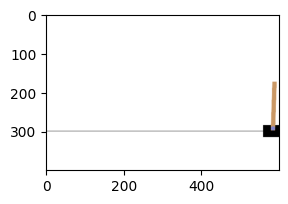

200.0

In [8]:
play(True)[-1]